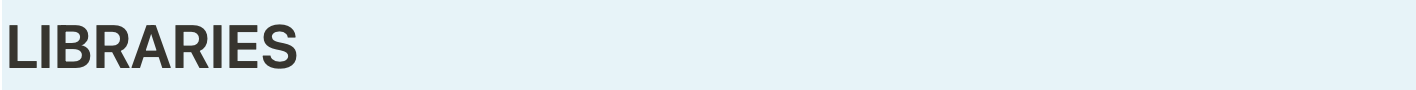

In [1]:
import os, re, glob, sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from scipy import ndimage
from skimage.transform import resize, rescale
from skimage.metrics import peak_signal_noise_ratio
from tensorflow.keras.preprocessing.image import img_to_array

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import VGG19

from tensorflow.keras.layers import (
    Input, Dense, Conv2D, MaxPooling2D, MaxPool2D, Dropout, Activation,
    Conv2DTranspose, UpSampling2D, add, BatchNormalization,
    Concatenate, LeakyReLU
)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import mixed_precision

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras import layers as L
from tensorflow.keras.utils import plot_model
from keras.saving import register_keras_serializable

# Set random seed for reproducibility
np.random.seed(0)

# Check TensorFlow version
print(tf.__version__)


2.16.2


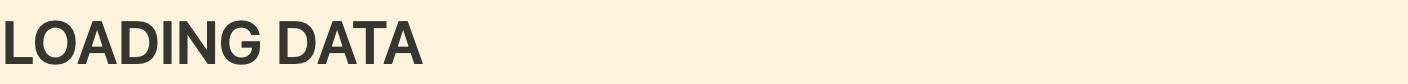

In [2]:
# === Configuration ===
LR_SIZE    = 256    # model input
HR_SIZE    = 512    # model target
BATCH_SIZE = 2     
AUTOTUNE   = tf.data.AUTOTUNE

base_dir        = '/Users/kunalnarwani/Desktop/Thesis/unet-thesis/Super-resolution-new/data/raw/div2k'
train_hr_dir    = os.path.join(base_dir, 'DIV2K_train_HR')
valid_hr_dir    = os.path.join(base_dir, 'DIV2K_valid_HR')

# human-friendly sort, if you really need it on filenames
def sorted_alphanumeric(file_list):
    convert    = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum   = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
    return sorted(file_list, key=alphanum)

# 1) gather all the HR filepaths
train_hr_paths = sorted_alphanumeric(glob.glob(os.path.join(train_hr_dir, '*.png')))
valid_hr_paths = sorted_alphanumeric(glob.glob(os.path.join(valid_hr_dir, '*.png')))

# 2) helper to load and decode an image from disk → float32 [0,1]
def load_image(path):
    data = tf.io.read_file(path)
    img  = tf.image.decode_png(data, channels=3)
    img  = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
    return img

# 3) on-the-fly preprocessing + augmentation
def preprocess_and_augment(hr):
    # a) random crop an HR patch
    hr = tf.image.random_crop(hr, size=[HR_SIZE, HR_SIZE, 3])
    # b) create the LR patch by bicubic down-sampling
    lr = tf.image.resize(hr, [LR_SIZE, LR_SIZE], method='bicubic')
    # c) random flips
    if tf.random.uniform(()) > 0.5:
        lr = tf.image.flip_left_right(lr);  hr = tf.image.flip_left_right(hr)
    if tf.random.uniform(()) > 0.5:
        lr = tf.image.flip_up_down(lr);     hr = tf.image.flip_up_down(hr)
    # d) random 90° rotations
    k = tf.random.uniform((), minval=0, maxval=4, dtype=tf.int32)
    lr = tf.image.rot90(lr, k);  hr = tf.image.rot90(hr, k)
    # e) simple color jitter on the LR 
    lr = tf.image.random_brightness(lr, max_delta=0.1)
    lr = tf.image.random_contrast(lr, lower=0.9, upper=1.1)
    return lr, hr

# 4) build the training Dataset
train_ds = (
    tf.data.Dataset
      .from_tensor_slices(train_hr_paths)
      .shuffle(len(train_hr_paths), seed=42)
      .map(lambda p: load_image(p),               num_parallel_calls=AUTOTUNE)
      .map(preprocess_and_augment,                num_parallel_calls=AUTOTUNE)
      .batch(BATCH_SIZE)
      .prefetch(AUTOTUNE)
)

# 5) build the validation Dataset (no augment, just center-crop/resize)
def preprocess_valid(hr):
    hr = tf.image.resize(hr, [HR_SIZE, HR_SIZE])
    lr = tf.image.resize(hr, [LR_SIZE, LR_SIZE], method='bicubic')
    return lr, hr

valid_ds = (
    tf.data.Dataset
      .from_tensor_slices(valid_hr_paths)
      .map(lambda p: load_image(p),   num_parallel_calls=AUTOTUNE)
      .map(preprocess_valid,          num_parallel_calls=AUTOTUNE)
      .batch(BATCH_SIZE)
      .prefetch(AUTOTUNE)
)

# 6) sanity-check shapes
for lr_batch, hr_batch in train_ds.take(1):
    print(" LR batch:", lr_batch.shape, " HR batch:", hr_batch.shape)


2025-09-18 14:01:01.832038: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-09-18 14:01:01.832129: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-09-18 14:01:01.832137: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-09-18 14:01:01.832325: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-18 14:01:01.832341: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


 LR batch: (2, 256, 256, 3)  HR batch: (2, 512, 512, 3)


2025-09-18 14:01:02.453730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# ARCITECTURE OF MODEL 


Model: "U-Net_SR_arbitrary_scale"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_52[0][0]   │
│ (LayerNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_44       │ (None, 256, 256,  │          0 │ layer_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 256, 256,  │     36,928 │ activation_44[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_53[0][0]   │
│ (LayerNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_45       │ (None, 256, 256,  │          0 │ layer_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_down            │ (None, 33, 33,    │          0 │ activation_45[0]… │
│ (ResizeByScale)     │ 512)              │            │ activation_47[0]… │
│                     │                   │            │ activation_49[0]… │
│                     │                   │            │ activation_51[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 154, 154,  │     73,856 │ enc_down[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 154, 154,  │        256 │ conv2d_54[0][0]   │
│ (LayerNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_46       │ (None, 154, 154,  │          0 │ layer_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 154, 154,  │    147,584 │ activation_46[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 154, 154,  │        256 │ conv2d_55[0][0]   │
│ (LayerNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_47       │ (None, 154, 154,  │          0 │ layer_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 92, 92,    │    295,168 │ enc_down[1][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 92, 92,    │        512 │ conv2d_56[0][0]   │
│ (LayerNormalizatio… │ 256)              │            │                 

 Total params: 34,747,075 (132.55 MB)

 Trainable params: 34,747,075 (132.55 MB)

 Non-trainable params: 0 (0.00 B)

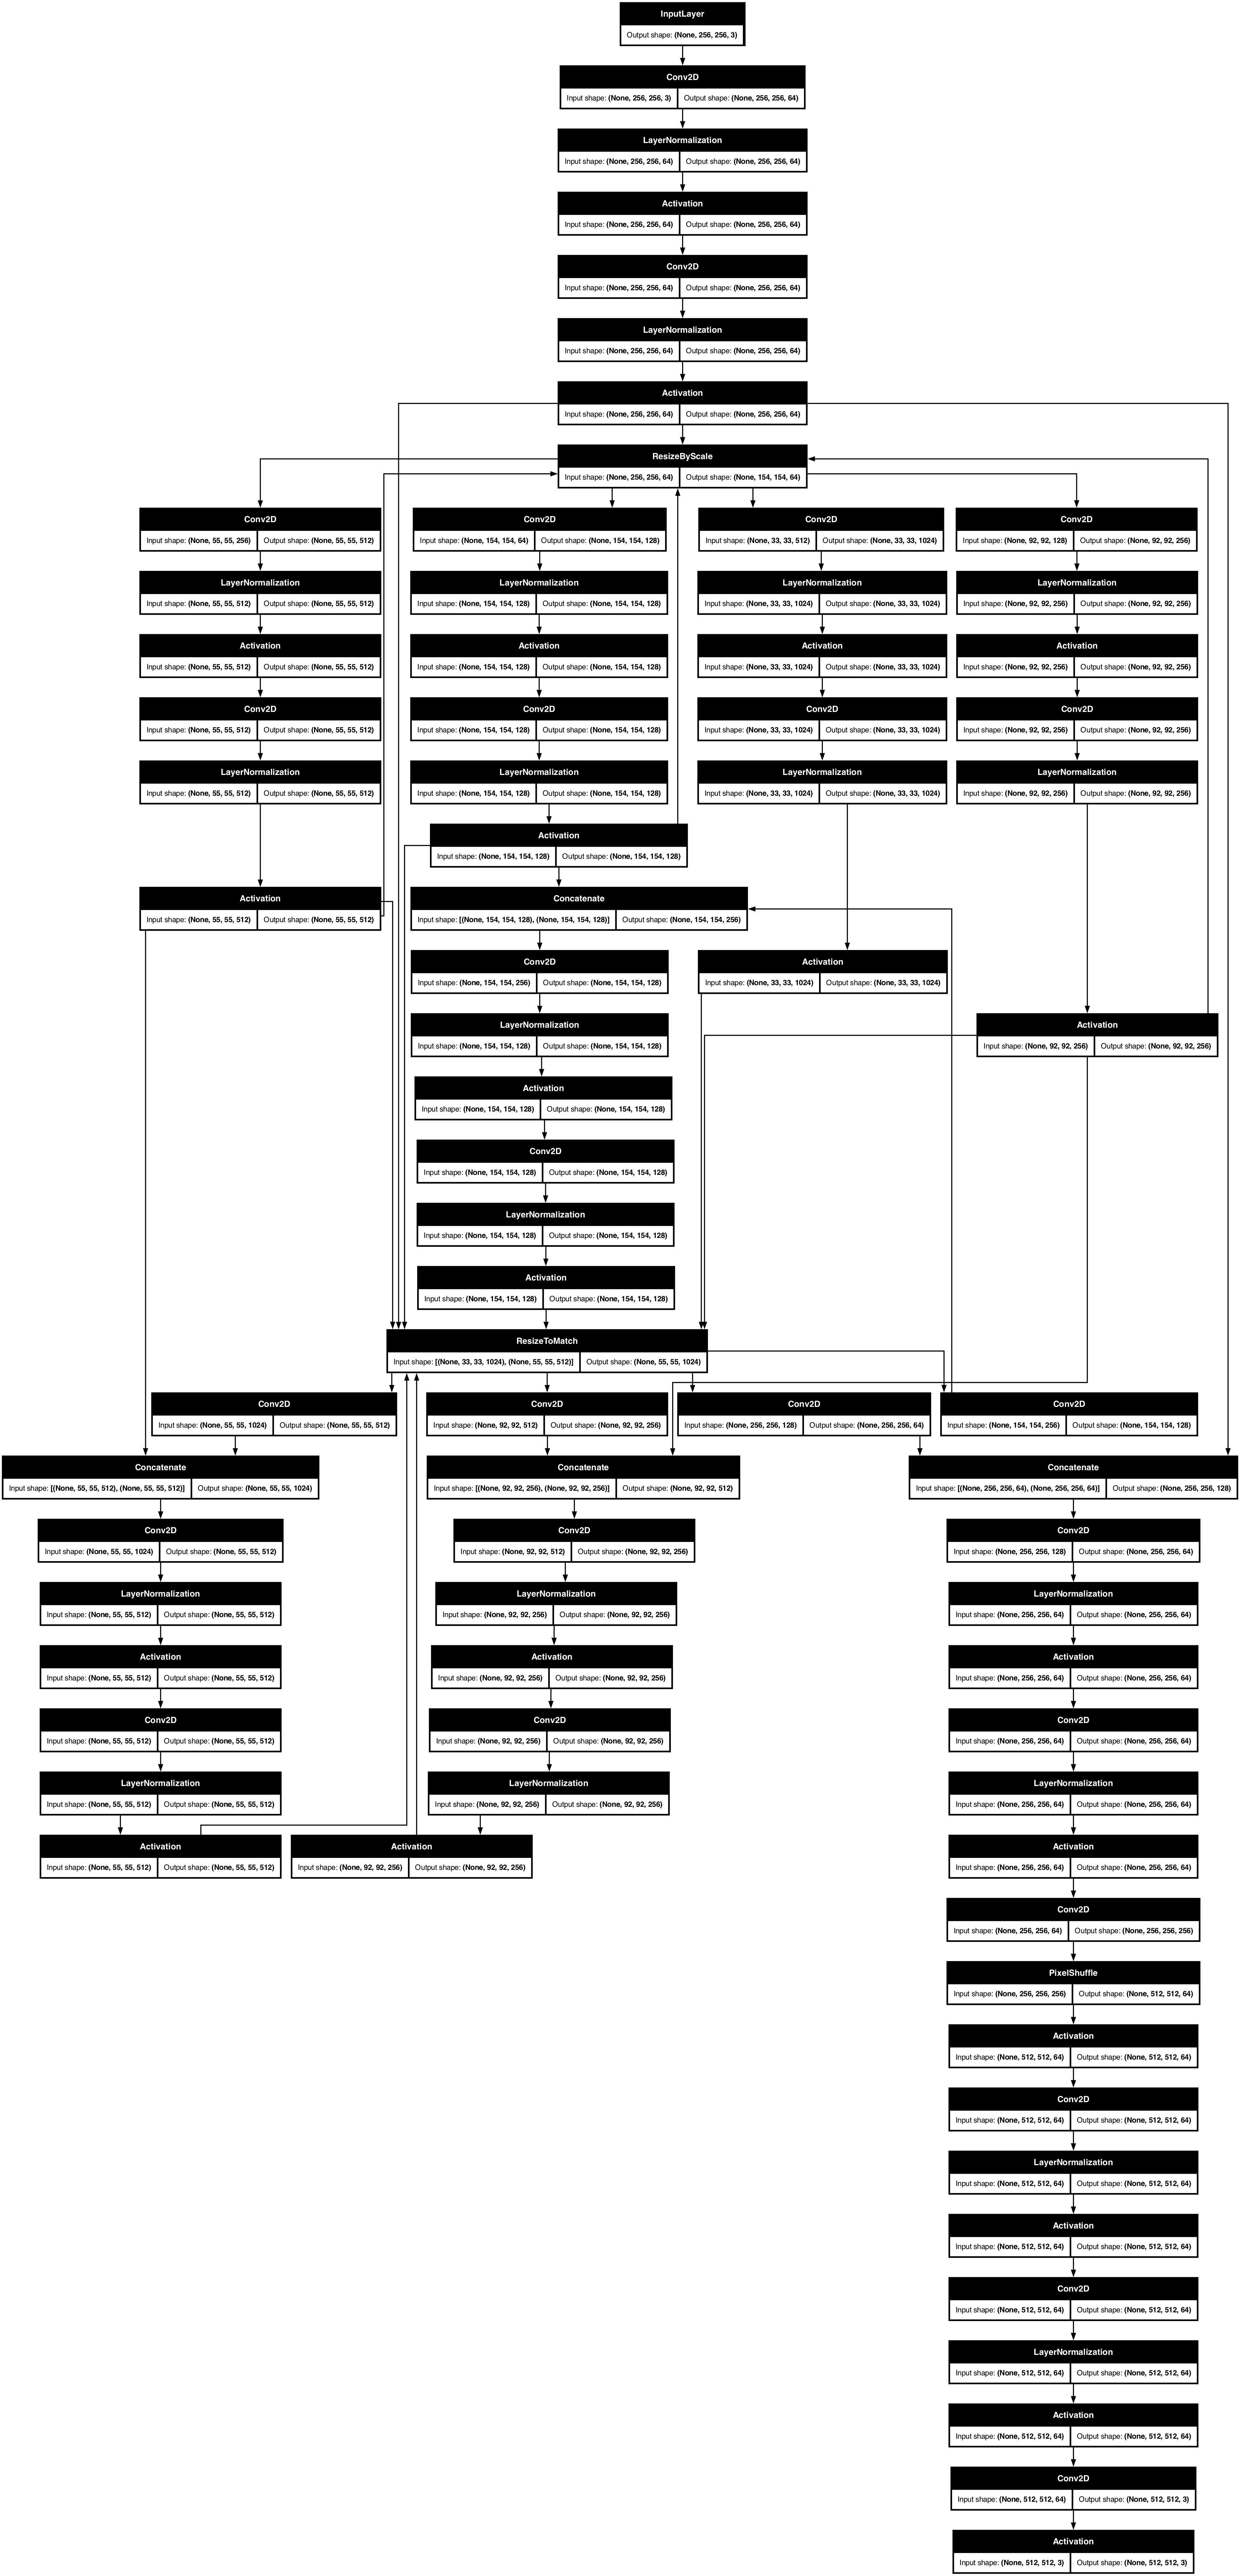

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras import Model, Input
from keras.saving import register_keras_serializable

@register_keras_serializable(package="resize")
class ResizeByScale(L.Layer):
    def __init__(self, scale, method="bilinear", antialias=True, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.scale = float(scale)
        self.method = method
        self.antialias = antialias

    def call(self, x):
        x_dtype = x.dtype
        h = tf.shape(x)[1]; w = tf.shape(x)[2]
        nh = tf.cast(tf.round(tf.cast(h, tf.float32) * self.scale), tf.int32)
        nw = tf.cast(tf.round(tf.cast(w, tf.float32) * self.scale), tf.int32)
        # upcast to f32 for resize (and antialias path), then cast back
        x_f32 = tf.cast(x, tf.float32)
        y = tf.image.resize(x_f32, size=[nh, nw], method=self.method, antialias=self.antialias)
        return tf.cast(y, x_dtype)

    def get_config(self):
        cfg = super().get_config()
        cfg.update({"scale": self.scale, "method": self.method, "antialias": self.antialias})
        return cfg


@register_keras_serializable(package="resize")
class ResizeToMatch(L.Layer):
    def __init__(self, method="bilinear", antialias=True, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.method = method
        self.antialias = antialias

    def call(self, inputs):
        x, ref = inputs
        x_dtype = x.dtype
        target = tf.shape(ref)[1:3]
        x_f32 = tf.cast(x, tf.float32)
        y = tf.image.resize(x_f32, size=target, method=self.method, antialias=self.antialias)
        return tf.cast(y, x_dtype)

    def get_config(self):
        cfg = super().get_config()
        cfg.update({"method": self.method, "antialias": self.antialias})
        return cfg

def conv_block(inputs, nf):
    # LayerNorm is more stable than BN for very small batches
    x = L.Conv2D(nf, 3, padding="same", use_bias=True)(inputs)
    x = L.LayerNormalization(axis=-1)(x); x = L.Activation("relu")(x)
    x = L.Conv2D(nf, 3, padding="same", use_bias=True)(x)
    x = L.LayerNormalization(axis=-1)(x); x = L.Activation("relu")(x)
    return x

DOWNSCALE = 0.6
down     = ResizeByScale(DOWNSCALE, method="bilinear", antialias=True, name="enc_down")
up_to    = ResizeToMatch(method="bilinear", antialias=True, name="dec_up")

def encoder_block(inputs, nf):
    x = conv_block(inputs, nf)
    p = down(x)
    return x, p

def decoder_block(inputs, skip_features, nf):
    x = up_to([inputs, skip_features])
    x = L.Conv2D(nf, 3, padding='same', activation='relu')(x)
    x = L.Concatenate()([x, skip_features])
    x = conv_block(x, nf)
    return x

# ---- NEW: Serializable PixelShuffle layer (replaces Lambda) ----
@register_keras_serializable(package="upsample")
class PixelShuffle(L.Layer):
    def __init__(self, r=2, **kwargs):
        super().__init__(**kwargs)
        self.r = int(r)
    def call(self, x):
        return tf.nn.depth_to_space(x, block_size=self.r)
    def get_config(self):
        cfg = super().get_config()
        cfg.update({"r": self.r})
        return cfg

# Sub-pixel (pixel-shuffle) upsampling for final 2x  (no Lambda anymore)
def subpixel_block(x, r=2, nf=64):
    x = L.Conv2D(nf * (r*r), 3, padding='same')(x)
    x = PixelShuffle(r=r, name=f"pixel_shuffle_x{r}")(x)
    x = L.Activation('relu')(x)
    return x
# ---------------------------------------------------------------

def build_super_resolution_unet(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)
    s1, p1 = encoder_block(inputs,  64)
    s2, p2 = encoder_block(p1,     128)
    s3, p3 = encoder_block(p2,     256)
    s4, p4 = encoder_block(p3,     512)
    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1,  64)

    u1 = subpixel_block(d4, r=2, nf=64)   # learnable 2× instead of bilinear
    u1 = conv_block(u1, 64)

    outputs = L.Activation("sigmoid")(L.Conv2D(3, 1, padding="same")(u1))
    return Model(inputs, outputs, name="U-Net_SR_arbitrary_scale")

model = build_super_resolution_unet((256, 256, 3))
model.summary()


In [22]:
# ===== Losses & Metrics (mixed-precision safe) =====
def _to_f32(y_true, y_pred):
    return tf.cast(y_true, tf.float32), tf.cast(y_pred, tf.float32)

def charbonnier_loss(y_true, y_pred, eps=1e-3):
    y_true, y_pred = _to_f32(y_true, y_pred)
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + eps**2))

def ssim_loss(y_true, y_pred):
    y_true, y_pred = _to_f32(y_true, y_pred)
    return 1.0 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

# perceptual backbone stays in float32
vgg = VGG19(include_top=False, weights='imagenet')
vgg.trainable = False
feat_extractor = Model(inputs=vgg.input, outputs=vgg.get_layer('block5_conv4').output)

def perceptual_loss(y_true, y_pred):
    y_true, y_pred = _to_f32(y_true, y_pred)
    yt = tf.keras.applications.vgg19.preprocess_input(y_true * 255.0)
    yp = tf.keras.applications.vgg19.preprocess_input(y_pred * 255.0)
    ft = feat_extractor(yt)
    fp = feat_extractor(yp)
    return tf.reduce_mean(tf.square(ft - fp))  # float32

# weighted sum in float32
α, β, γ = 1.0, 0.1, 0.01
def combined_loss(y_true, y_pred):
    l1   = tf.cast(charbonnier_loss(y_true, y_pred), tf.float32)
    lss  = tf.cast(ssim_loss(y_true, y_pred), tf.float32)
    lp   = tf.cast(perceptual_loss(y_true, y_pred), tf.float32)
    return α*l1 + β*lss + γ*lp

# metrics also cast to float32
def psnr_metric(y_true, y_pred):
    y_true, y_pred = _to_f32(y_true, y_pred)
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim_metric(y_true, y_pred):
    y_true, y_pred = _to_f32(y_true, y_pred)
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

In [23]:
# ============================== Optimizer / compile ========================= #
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

opt = tf.keras.optimizers.AdamW(
    learning_rate=1e-4,
    weight_decay=1e-4,
    clipnorm=1.0
)
model.compile(
    optimizer=opt,
    loss=combined_loss,
    metrics=[psnr_metric, ssim_metric],
    jit_compile=False
)

print("python exec:", sys.executable)
print("TF version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))

python exec: /Users/kunalnarwani/Desktop/Thesis/unet-thesis/.venv/bin/python
TF version: 2.16.2
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [24]:
# ============================== Paths ======================================= #
RUN_DIR   = "/Users/kunalnarwani/Desktop/Thesis/unet-thesis/Super-resolution-new/new-notebook/super-resolution-u-net-0.6"
MODEL_DIR = "/Users/kunalnarwani/Desktop/Thesis/unet-thesis/Super-resolution-new/models"
os.makedirs(RUN_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

# Use a new name so you don't overwrite the old Lambda-based .keras
BEST_MODEL_PATH = os.path.join(MODEL_DIR, "best_by_psnr_clean.keras")
BEST_WEIGHTS_PATH = os.path.join(MODEL_DIR, "best_by_psnr.weights.h5")

HISTORY_CSV = os.path.join(RUN_DIR, "history.csv")
BACKUP_DIR  = os.path.join(RUN_DIR, "backup_state")

# ============================== Callbacks =================================== #
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_psnr_metric',
    mode='max',
    patience=20,
    min_delta=0.05,
    restore_best_weights=True,
    verbose=1
)

# Save best full model (now fully serializable; no Lambda)
ckpt_best = ModelCheckpoint(
    filepath=BEST_MODEL_PATH,
    monitor='val_psnr_metric',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Save best weights (unchanged)
ckpt_best_weights = ModelCheckpoint(
    filepath=BEST_WEIGHTS_PATH,
    monitor='val_psnr_metric',
    mode='max',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

# ... (csv_log, backup, reduce_lr, tb) unchanged ...

# ============================== Train ======================================= #
EPOCHS = 100
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_ds,
    validation_steps=validation_steps,
    callbacks=[early_stop, ckpt_best, ckpt_best_weights, csv_log, reduce_lr, backup, tb],
    initial_epoch=initial_epoch,
    verbose=2,
)

# Save last snapshot to new names as well
final_path = os.path.join(MODEL_DIR, "last_epoch_clean.keras")
model.save(final_path)

LAST_WEIGHTS_PATH = os.path.join(MODEL_DIR, "last_epoch.weights.h5")
model.save_weights(LAST_WEIGHTS_PATH)
print(f"[saved] final model -> {final_path}")
print(f"[saved] final weights -> {LAST_WEIGHTS_PATH}")

Epoch 1/100


/Users/kunalnarwani/Desktop/Thesis/unet-thesis/.venv/lib/python3.11/site-packages/tensorflow/python/framework/tensor_util.py:504: RuntimeWarning: overflow encountered in cast
  nparray = values.astype(dtype.as_numpy_dtype)



Epoch 1: val_psnr_metric improved from -inf to 19.43624, saving model to /Users/kunalnarwani/Desktop/Thesis/unet-thesis/Super-resolution-new/models/best_by_psnr_clean.keras

Epoch 1: val_psnr_metric improved from -inf to 19.43624, saving model to /Users/kunalnarwani/Desktop/Thesis/unet-thesis/Super-resolution-new/models/best_by_psnr.weights.h5
400/400 - 1143s - 3s/step - loss: inf - psnr_metric: 16.9645 - ssim_metric: 0.5824 - val_loss: inf - val_psnr_metric: 19.4362 - val_ssim_metric: 0.6702 - learning_rate: 1.0000e-04
Epoch 2/100


KeyboardInterrupt: 

In [28]:
import numpy as np
import tensorflow as tf
from keras.saving import load_model

# --- Load the serializable model (PixelShuffle version) ---
model = load_model(
    "/Users/kunalnarwani/Desktop/Thesis/unet-thesis/Super-resolution-new/models/best_by_psnr_clean.keras",
    compile=False
)

# ---------- Build a NON-repeating eval dataset ----------
# Reuse your helpers already defined: load_image, preprocess_valid, valid_hr_paths, BATCH_SIZE
eval_ds = (
    tf.data.Dataset
      .from_tensor_slices(valid_hr_paths)
      .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
      .map(preprocess_valid, num_parallel_calls=tf.data.AUTOTUNE)  # yields (lr, hr) in [0,1]
      .batch(BATCH_SIZE)
      .prefetch(tf.data.AUTOTUNE)
)

# ---------- Batched evaluation ----------
all_psnr = []
all_ssim = []
all_msssim = []
n_images = 0

for lr_b, hr_b in eval_ds:
    # Forward pass (faster than model.predict for small loops)
    pred_b = model(lr_b, training=False)

    # If model output size differs from HR, resize the whole batch once
    if pred_b.shape[1:3] != hr_b.shape[1:3]:
        pred_b = tf.image.resize(pred_b, size=hr_b.shape[1:3], method="bicubic")

    # Ensure valid range/dtypes for metrics
    hr_tf   = tf.cast(hr_b, tf.float32)
    pred_tf = tf.cast(tf.clip_by_value(pred_b, 0.0, 1.0), tf.float32)

    # Batched metrics (each returns shape [batch,])
    psnr_b   = tf.image.psnr(hr_tf, pred_tf, max_val=1.0)
    ssim_b   = tf.image.ssim(hr_tf, pred_tf, max_val=1.0)
    mssim_b  = tf.image.ssim_multiscale(hr_tf, pred_tf, max_val=1.0)

    # Collect as numpy
    all_psnr.append(psnr_b.numpy())
    all_ssim.append(ssim_b.numpy())
    all_msssim.append(mssim_b.numpy())

    n_images += int(hr_b.shape[0])

# ---------- Aggregate ----------
psnr_vals   = np.concatenate(all_psnr,   axis=0)
ssim_vals   = np.concatenate(all_ssim,   axis=0)
msssim_vals = np.concatenate(all_msssim, axis=0)

def mean_std(x):
    x = np.asarray(x, dtype=np.float64)
    return float(np.mean(x)), float(np.std(x))

m_psnr, s_psnr     = mean_std(psnr_vals)
m_ssim, s_ssim     = mean_std(ssim_vals)
m_msssim, s_msssim = mean_std(msssim_vals)

print(f"Validation images evaluated: {n_images}")
print(f" PSNR    : {m_psnr:.4f} ± {s_psnr:.4f} dB")
print(f" SSIM    : {m_ssim:.4f} ± {s_ssim:.4f}")
print(f" MS-SSIM : {m_msssim:.4f} ± {s_msssim:.4f}")

Validation images evaluated: 100
 PSNR    : 19.4389 ± 2.3109 dB
 SSIM    : 0.6702 ± 0.1080
 MS-SSIM : 0.9109 ± 0.0340


2025-09-18 15:43:27.448843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [29]:
# === OPTIONAL: VISUAL CHECK (enhanced) ===
import numpy as np
import matplotlib.pyplot as plt
import cv2

for lr, hr in valid_ds.take(1):
    pred = model.predict(lr, verbose=1)
    i = 1

    # Tensors -> np and basic prep
    hr_i   = hr[i].numpy()                        # (H, W, 3), float32 in [0,1]
    lr_i   = lr[i].numpy()                        # (h, w, 3), float32 in [0,1]
    pred_i = pred[i]                              # (H?, W?, 3), float32 (0..1-ish)

    # If output size differs from HR, resize prediction (and LR for fair side-by-side)
    H, W = hr_i.shape[:2]
    if pred_i.shape[:2] != (H, W):
        pred_i = cv2.resize(pred_i, (W, H), interpolation=cv2.INTER_CUBIC)
    if lr_i.shape[:2] != (H, W):
        lr_up = cv2.resize(lr_i, (W, H), interpolation=cv2.INTER_CUBIC)
    else:
        lr_up = lr_i

    # Clip to [0,1] for safe display
    hr_i   = np.clip(hr_i,   0, 1)
    lr_up  = np.clip(lr_up,  0, 1)
    pred_i = np.clip(pred_i, 0, 1)

    # --- 1) Absolute difference heatmap (HR vs Pred) ---
    diff = np.abs(hr_i - pred_i)                 # (H, W, 3)
    diff_gray = diff.mean(axis=2)                # (H, W)

    # --- 2) Auto-zoom around the largest error ---
    def crop_around(yx, size, H, W):
        cy, cx = yx
        hh = size // 2
        y1 = max(0, cy - hh); y2 = min(H, cy + hh)
        x1 = max(0, cx - hh); x2 = min(W, cx + hh)
        return slice(y1, y2), slice(x1, x2)

    maxy, maxx = np.unravel_index(np.argmax(diff_gray), diff_gray.shape)
    crop_size = min(128, min(H, W))  # reasonable default
    ys, xs = crop_around((maxy, maxx), crop_size, H, W)

    hr_crop   = hr_i[ys, xs]
    pred_crop = pred_i[ys, xs]
    diff_crop = diff_gray[ys, xs]

    # --- 2a) Corresponding LR crops (native and upsampled) ---
    # Map HR crop window to LR-native coordinates
    h_lr, w_lr = lr_i.shape[:2]
    sy = h_lr / float(H)
    sx = w_lr / float(W)

    lr_y1 = int(round(ys.start * sy)); lr_y2 = int(round(ys.stop * sy))
    lr_x1 = int(round(xs.start * sx)); lr_x2 = int(round(xs.stop * sx))

    # Keep indices in bounds and ensure at least 1 pixel
    lr_y1 = np.clip(lr_y1, 0, max(0, h_lr - 1))
    lr_y2 = np.clip(max(lr_y2, lr_y1 + 1), 1, h_lr)
    lr_x1 = np.clip(lr_x1, 0, max(0, w_lr - 1))
    lr_x2 = np.clip(max(lr_x2, lr_x1 + 1), 1, w_lr)

    lr_native_crop = lr_i[lr_y1:lr_y2, lr_x1:lr_x2]                   # native LR crop
    # Upsample native LR crop to the same display size as HR crop (to see blockiness)
    lr_native_crop_up = cv2.resize(
        lr_native_crop,
        (hr_crop.shape[1], hr_crop.shape[0]),
        interpolation=cv2.INTER_NEAREST
    )
    # Also crop from the already upsampled LR image (same window as HR)
    lr_up_crop = lr_up[ys, xs]

    # --- 3) Edge maps (Sobel) + edge difference (full image) ---
    def to_gray_u8(x):
        g = (0.299*x[...,0] + 0.587*x[...,1] + 0.114*x[...,2])
        g = np.clip(g*255.0, 0, 255).astype(np.uint8)
        return g

    hr_g   = to_gray_u8(hr_i)
    pred_g = to_gray_u8(pred_i)

    sobelx_hr = cv2.Sobel(hr_g,   cv2.CV_32F, 1, 0, ksize=3)
    sobely_hr = cv2.Sobel(hr_g,   cv2.CV_32F, 0, 1, ksize=3)
    edges_hr  = np.hypot(sobelx_hr, sobely_hr)

    sobelx_pr = cv2.Sobel(pred_g, cv2.CV_32F, 1, 0, ksize=3)
    sobely_pr = cv2.Sobel(pred_g, cv2.CV_32F, 0, 1, ksize=3)
    edges_pr  = np.hypot(sobelx_pr, sobely_pr)

    edge_diff = np.abs(edges_hr - edges_pr)

    def norm01(x):
        x = x.astype(np.float32)
        m, M = np.min(x), np.max(x)
        return (x - m) / (M - m + 1e-8)

    edges_hr_n  = norm01(edges_hr)
    edges_pr_n  = norm01(edges_pr)
    edge_diff_n = norm01(edge_diff)

    # --- Plot grid ---
    # Row1: HR / LR-up / Pred / Abs Diff / Edge Diff (full image)
    # Row2: HR (zoom) / LR (native→upsampled, zoom) / LR-up (zoom) / Pred (zoom) / Diff (zoom)
    fig, axs = plt.subplots(2, 5, figsize=(20, 8))

    axs[0,0].imshow(hr_i);     axs[0,0].set_title("HR");                 axs[0,0].axis("off")
    axs[0,1].imshow(lr_up);    axs[0,1].set_title("LR (upsampled)");     axs[0,1].axis("off")
    axs[0,2].imshow(pred_i);   axs[0,2].set_title("Pred");               axs[0,2].axis("off")
    im = axs[0,3].imshow(diff_gray, cmap="hot")
    axs[0,3].set_title("Abs Diff (HR − Pred)"); axs[0,3].axis("off")
    axs[0,4].imshow(edge_diff_n, cmap="gray")
    axs[0,4].set_title("Edge Difference (Sobel)"); axs[0,4].axis("off")

    axs[1,0].imshow(hr_crop);             axs[1,0].set_title("HR (zoom)");                    axs[1,0].axis("off")
    axs[1,1].imshow(lr_native_crop_up);   axs[1,1].set_title("LR (native→upsampled, zoom)");  axs[1,1].axis("off")
    axs[1,2].imshow(lr_up_crop);          axs[1,2].set_title("LR-up (zoom)");                 axs[1,2].axis("off")
    axs[1,3].imshow(pred_crop);           axs[1,3].set_title("Pred (zoom)");                  axs[1,3].axis("off")
    im2 = axs[1,4].imshow(diff_crop, cmap="hot")
    axs[1,4].set_title("Diff (zoom)");    axs[1,4].axis("off")

    # Colorbars for the two heatmaps
    cbar1 = fig.colorbar(im,  ax=axs[0,3], fraction=0.046, pad=0.04)
    cbar2 = fig.colorbar(im2, ax=axs[1,4], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()
    break

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.005937609..0.8640298].


ValueError: arrays must be of dtype byte, short, float32 or float64

<Figure size 2000x800 with 12 Axes>